In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd /content/gdrive/MyDrive/DeepST_run/DeepST/deepst

/content/gdrive/MyDrive/DeepST_run/DeepST/deepst


In [5]:
!ls

adj.py	    _compat.py	his_feat.py  __pycache__  run_deepst.ipynb  utils_func.py
augment.py  DeepST.py	model.py     README	  trainer.py


In [6]:
!pip install scanpy

In [7]:
!pip install torch_sparse

In [8]:
!pip install torch_scatter

In [9]:
!pip install torch_geometric

In [10]:
!pip install scikit-network


In [11]:
import os
from DeepST import run
import matplotlib.pyplot as plt
from pathlib import Path
import scanpy as sc

In [12]:
!pip install leidenalg

In [13]:
!pip install louvain


In [14]:
data_path = "/content/gdrive/MyDrive/DeepST_run/DeepST/data/DLPFC" #### to your path
data_name = '151507' #### project name
save_path = "/content/gdrive/MyDrive/DeepST_run/DeepST/Results/Figure/151507" #### save path
n_domains = 7 ###### the number of spatial domains

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
Tiling image: 100%|██████████ [ time left: 00:00 ]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=R

Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 33.741126360624705
Gene correlation calculting Done!
Morphological similarity calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|██████████ [ time left: 00:00 ]


Step 1: Augment molecule expression is Done!
12.0000 neighbors per cell on average.
Step 2: Graph computing is Done!


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|           [ time left: ? ]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |           [ time left: 00:00 ]


Step 3: DeepST training has been Done!
Current memory usage：5.6967 GB
Total time: 1.16 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data
Best resolution:  0.5499999999999998


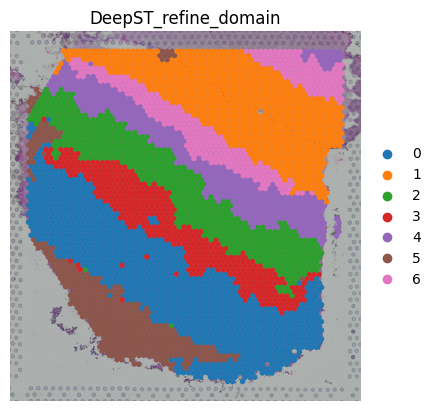

<Figure size 640x480 with 0 Axes>

In [16]:
deepen = run(save_path = save_path,
	task = "Identify_Domain", #### DeepST includes two tasks, one is "Identify_Domain" and the other is "Integration"
	pre_epochs = 800, ####  choose the number of training
	epochs = 1000, #### choose the number of training
	use_gpu = True)
adata = deepen._get_adata(platform="Visium", data_path=data_path, data_name=data_name)
###### Segment the Morphological Image
adata = deepen._get_image_crop(adata, data_name=data_name)

###### Data augmentation. spatial_type includes three kinds of "KDTree", "BallTree" and "LinearRegress", among which "LinearRegress"
###### is only applicable to 10x visium and the remaining omics selects the other two.
###### "use_morphological" defines whether to use morphological images.
adata = deepen._get_augment(adata, spatial_type="LinearRegress", use_morphological=True)

###### Build graphs. "distType" includes "KDTree", "BallTree", "kneighbors_graph", "Radius", etc., see adj.py
graph_dict = deepen._get_graph(adata.obsm["spatial"], distType = "BallTree")

###### Enhanced data preprocessing
data = deepen._data_process(adata, pca_n_comps = 200)

###### Training models
deepst_embed = deepen._fit(
		data = data,
		graph_dict = graph_dict,)
###### DeepST outputs
adata.obsm["DeepST_embed"] = deepst_embed

###### Define the number of space domains, and the model can also be customized. If it is a model custom priori = False.
adata = deepen._get_cluster_data(adata, n_domains=n_domains, priori = True)

###### Spatial localization map of the spatial domain
sc.pl.spatial(adata, color='DeepST_refine_domain', frameon = False, spot_size=150)
plt.savefig(os.path.join(save_path, f'{data_name}_domains.pdf'), bbox_inches='tight', dpi=300)


In [17]:
adata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'slices_path', 'leiden', 'DeepST_domain', 'DeepST_refine_domain'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'neighbors', 'leiden', 'DeepST_refine_domain_colors'
    obsm: 'spatial', 'image_feat', 'image_feat_pca', 'weights_matrix_all', 'adjacent_data', 'augment_gene_data', 'DeepST_embed'
    obsp: 'distances', 'connectivities'

In [18]:
import pandas as pd

from sklearn import metrics
df_meta = pd.read_csv('/content/gdrive/MyDrive/DeepST_run/DeepST/data/DLPFC/151507/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['Ground_Truth'] = df_meta_layer.values
adata = adata[~pd.isnull(adata.obs['Ground_Truth'])]

In [19]:
adata

View of AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'slices_path', 'leiden', 'DeepST_domain', 'DeepST_refine_domain', 'Ground_Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'neighbors', 'leiden', 'DeepST_refine_domain_colors'
    obsm: 'spatial', 'image_feat', 'image_feat_pca', 'weights_matrix_all', 'adjacent_data', 'augment_gene_data', 'DeepST_embed'
    obsp: 'distances', 'connectivities'

In [20]:
ARI = metrics.adjusted_rand_score(adata.obs['DeepST_refine_domain'], adata.obs['Ground_Truth'])
adata.uns['ARI'] = ARI
print('ARI:', ARI)

<ipython-input-20-bceacc4eaa21>:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


ARI: 0.5529084576884492


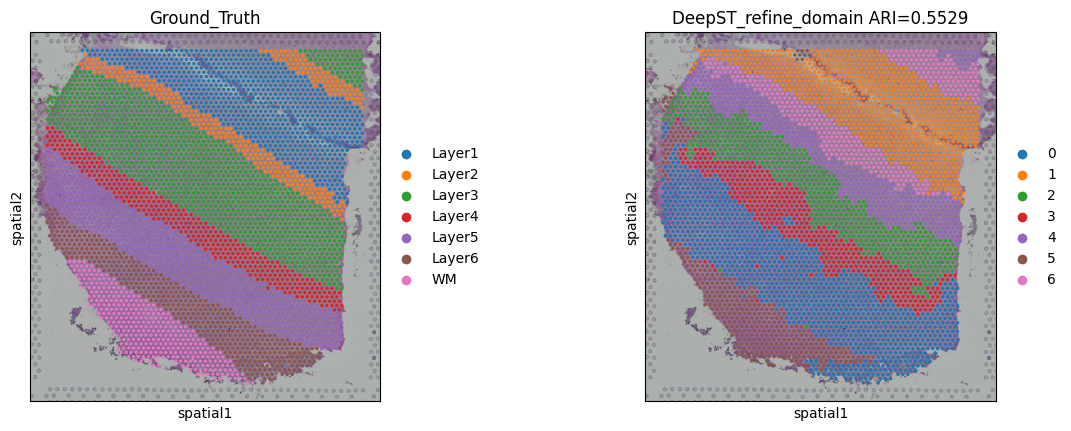

In [21]:
sc.pl.spatial(adata,
              img_key="hires",
              color=["Ground_Truth", "DeepST_refine_domain"],
              title=["Ground_Truth", "DeepST_refine_domain ARI=%.4f"%ARI],
              show=True)